# Growth and seasonal component analysis in time series

We look at the Mauna Loa observatory measurments of atmospheric $CO_2$, more specifically, the monthly dataset from 1958 to 2019, trying to understand the long-term growth and the monthly seasonality. The dataset can be downloaded [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo).

In [1]:
from datetime import timedelta, date
import calendar

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as tt
import arviz as az

pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-v0_8-whitegrid')
%config InlineBackend.figure_format='retina'

### Loading the data

In [2]:
data = pd.read_csv('monthly_in_situ_co2_mlo.csv', header=57)
data = data.iloc[2:]


data.columns = ["year", "month", "_1", "_2", "CO2", "_3", "_4", "_5", "_6", "_7", "_8"]
data = data[['year', 'month', 'CO2']]

# missing data is marked as -99.99
data = data.replace(to_replace='  -99.99', value=np.nan)
data = data.dropna()
data = data.assign(
    year=data.year.astype('int'),
    month=data.month.astype('int'),
    CO2 = data.CO2.astype('float')
)

data = data.assign(date = pd.to_datetime(data[['year', 'month']].apply(lambda r: date(r.year, r.month, 1), axis=1)),
                   t = data.year * 12 + data.month - 1)
data = data.assign(t = data.t - data.t.min())
data.sample(10)

,year,month,CO2,date,t
244,1978,3,336.65,1978-03-01,240
591,2007,2,383.68,2007-02-01,587
594,2007,5,386.38,2007-05-01,590
174,1972,5,330.07,1972-05-01,170
206,1975,1,330.41,1975-01-01,202
280,1981,3,341.40,1981-03-01,276
138,1969,5,327.38,1969-05-01,134
109,1966,12,321.02,1966-12-01,105
569,2005,4,382.01,2005-04-01,565
219,1976,2,332.58,1976-02-01,215


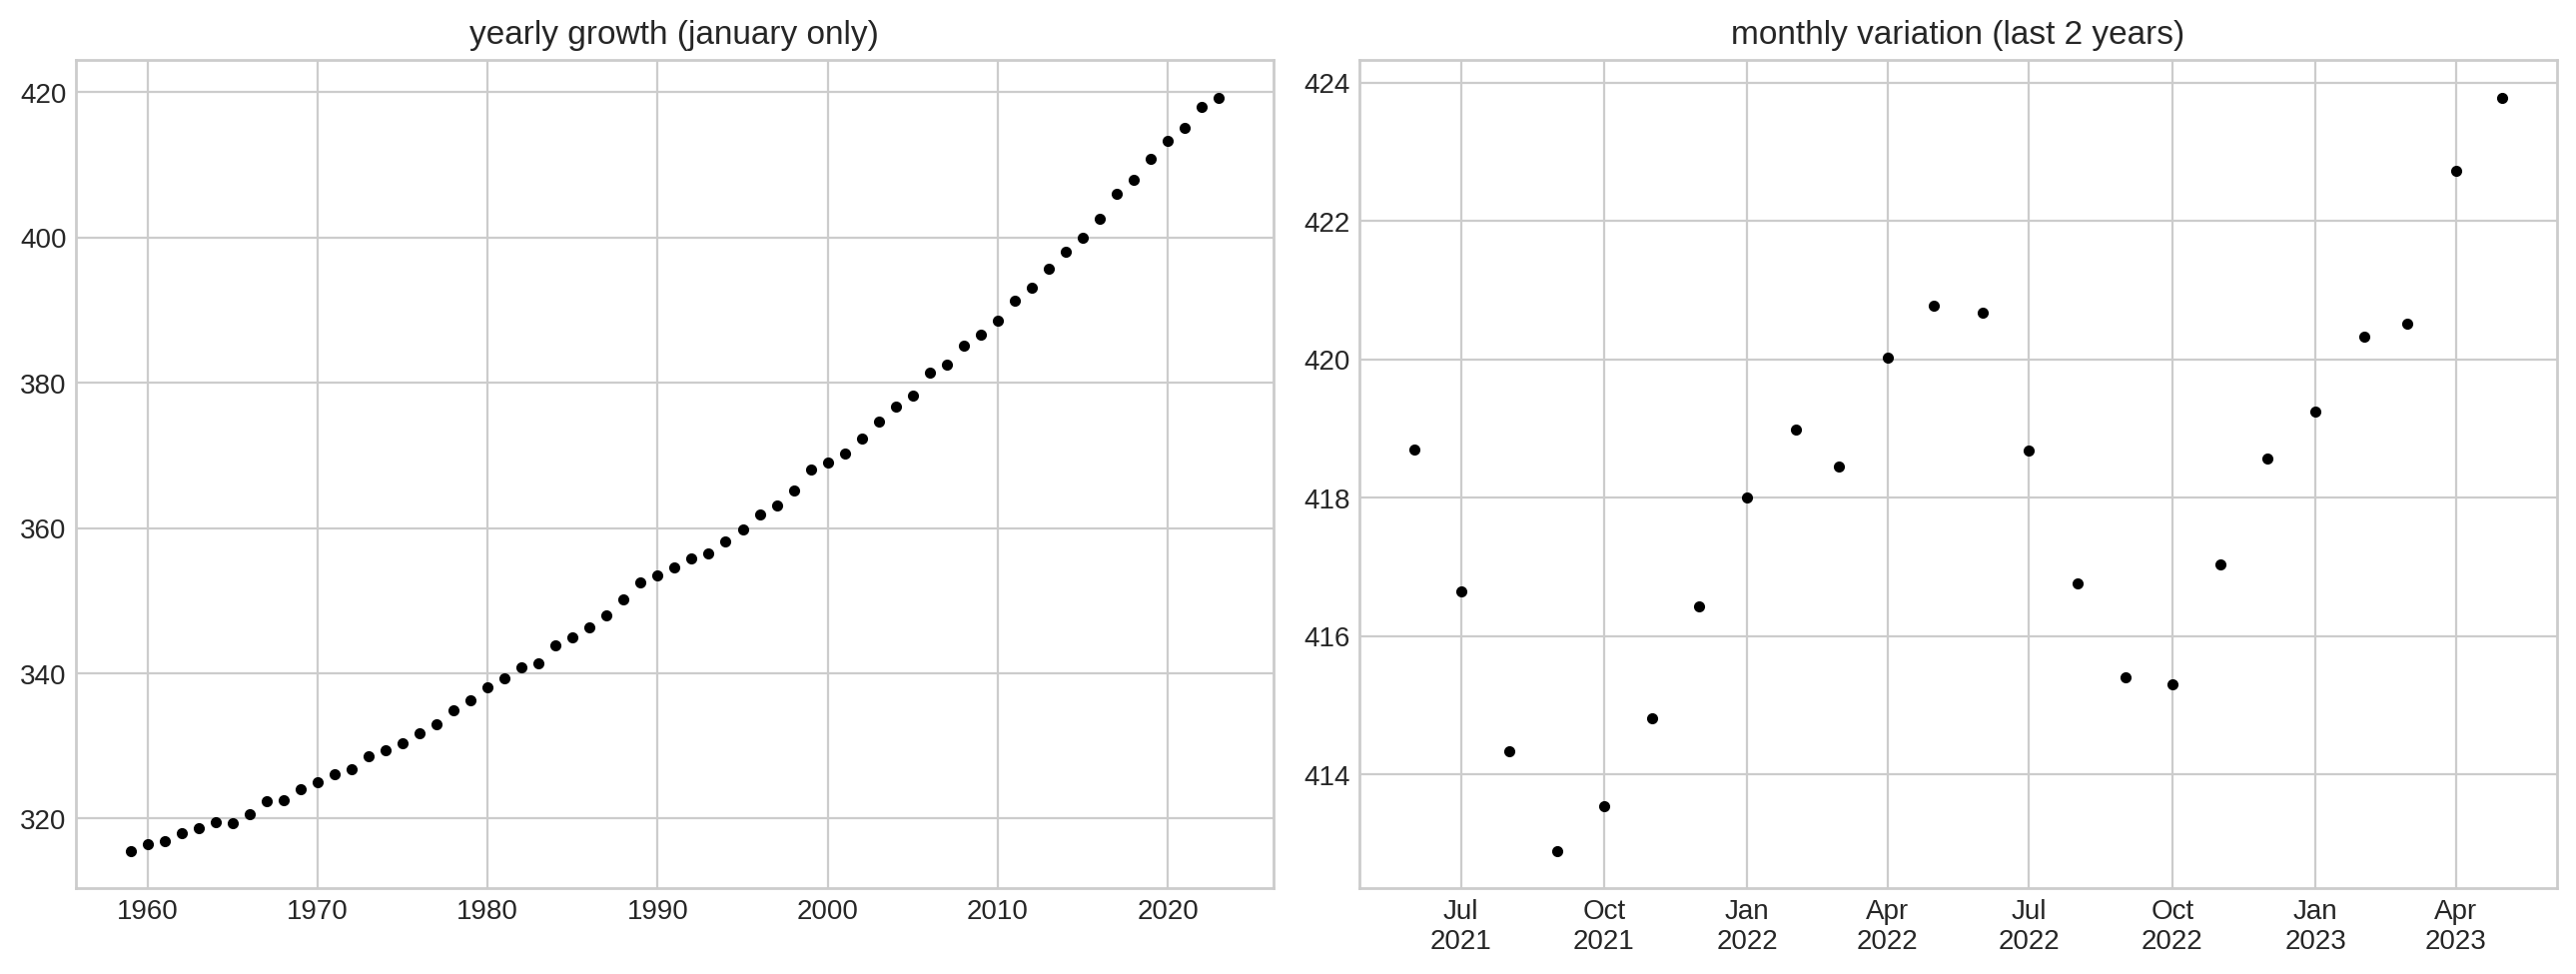

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(data[data.month == 1].year, data[data.month == 1].CO2, marker='.', c='k')
ax1.set(title='yearly growth (january only)')
ax2.scatter(data.date[-24:], data.CO2[-24:], marker='.', c='k')
ax2.set(title='monthly variation (last 2 years)')
ax2.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
fig.tight_layout()
None

## Model

We start with choosing the normal distribution as the likelihood of observing a certain value for the  $\text{CO}_2$ measurement:

$$ \text{CO}_2 \sim \mathcal{N}(\mu, \sigma) $$

We will use a two-component model:

$$ \mu_t = g(t) + p(m) $$

where $t$ is the number of months since the first one (March 1958), and $m$ is the month in the year, from 0 to 11.

We will use a local-linear model with Gaussian random walk for the trend:

$$ g_t \sim \mathcal N \big( g_{t-1} + b_{t}, 0.1^2 \big) $$

$$ b_t \sim \mathcal N \big( b_{t-1}, 0.01^2 \big) $$

where $b$ can be interpreted as the local slope that's also changing over time.

The periodical component $p$ can be modeled with an inverse Fourier transorm with period of 12 and order of 3:

$$ p(m) = \sum_{k=1}^{3}\big( {S_k \sin{\frac{2 \pi k m}{12}} + C_k \cos{\frac{2 \pi k m}{12}  } }\big) $$

What remains is choosing priors for the free parameters in the model:

$$ \sigma \sim \text{Half-Normal}(0.5) $$

$$ S_k, C_k \sim \mathcal{N}(0, 0.5^2), k = 1, 2, 3 $$

In [4]:
# fourier transform order
ft_order = 2
n_t = int(data.t.max()) + 1

phi_k = np.array([
    2 * np.pi * k * np.arange(0, 13) / 12
    for k in range(1, ft_order+1)
])

with pm.Model() as m1:
    b = pm.GaussianRandomWalk(
        'b', sigma=0.003, init_dist=pm.Normal.dist(0, 0.5), shape=n_t-1
    )
    
    g = pm.GaussianRandomWalk(
        'g', mu=b, sigma=0.3, init_dist=pm.Normal.dist(300, 10), shape=n_t
    )

    # inverse fourier
    Sk = pm.Normal('Sk', 0, 0.5, shape=ft_order)
    Ck = pm.Normal('Ck', 0, 0.5, shape=ft_order)

    s = pm.Deterministic('s', tt.dot(Sk, np.sin(phi_k)) + tt.dot(Ck, np.cos(phi_k)))

    g_i = g[data.t.values]
    s_i = s[data.date.dt.month.values - 1]
    mu_i = pm.Deterministic('mu', g_i + s_i)

    # inference
    sigma = pm.HalfNormal('sigma', 0.5)
    pm.Normal('obs', mu_i, sigma, observed=data.CO2.values)

    tr1 = pm.sampling_jax.sample_numpyro_nuts(3000, tune=3000, chains=2)

Compiling...


Compilation time =  0:00:03.283012
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:01:30.806773
Transforming variables...
Transformation time =  0:00:00.226756


In [5]:
trd = az.extract(tr1)

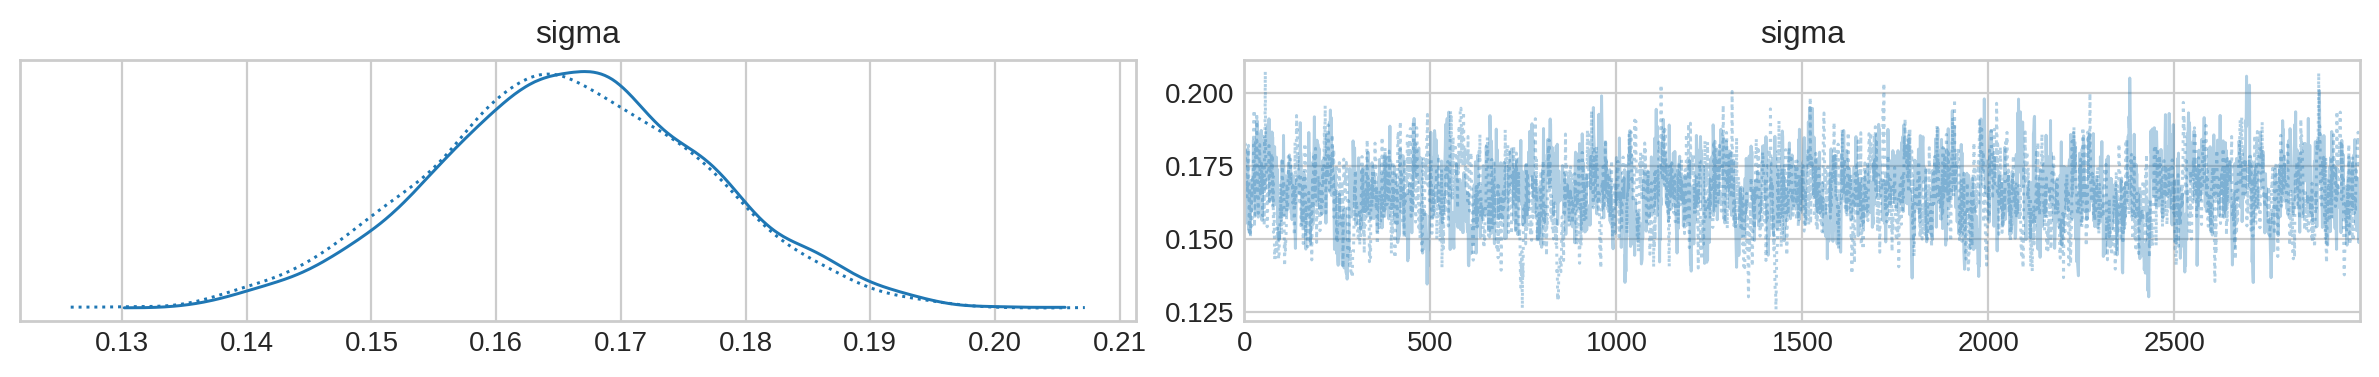

In [6]:
az.plot_trace(tr1, var_names=[ 'sigma'])
plt.gcf().tight_layout()
None

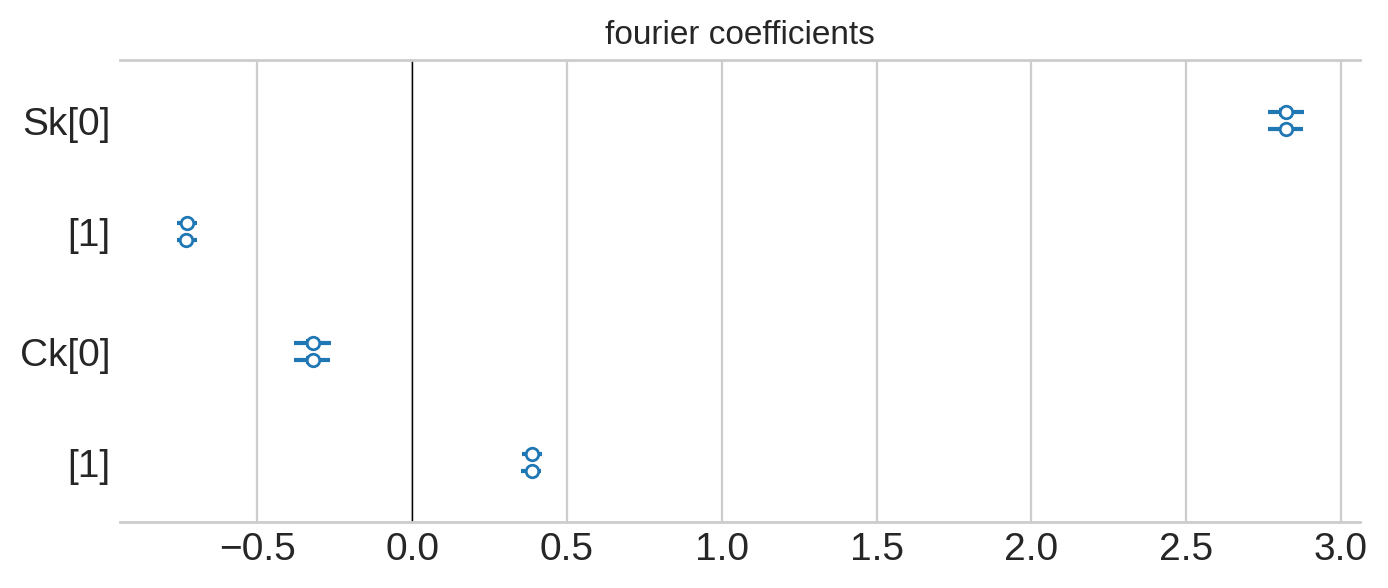

In [7]:
az.plot_forest(tr1, var_names=['Sk', 'Ck'], figsize=(8, 3))
plt.axvline(color='k', linewidth=0.5)
plt.gca().set(title='fourier coefficients')
None

/tmp/ipykernel_2639/1595745212.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.s.to_numpy().T).T


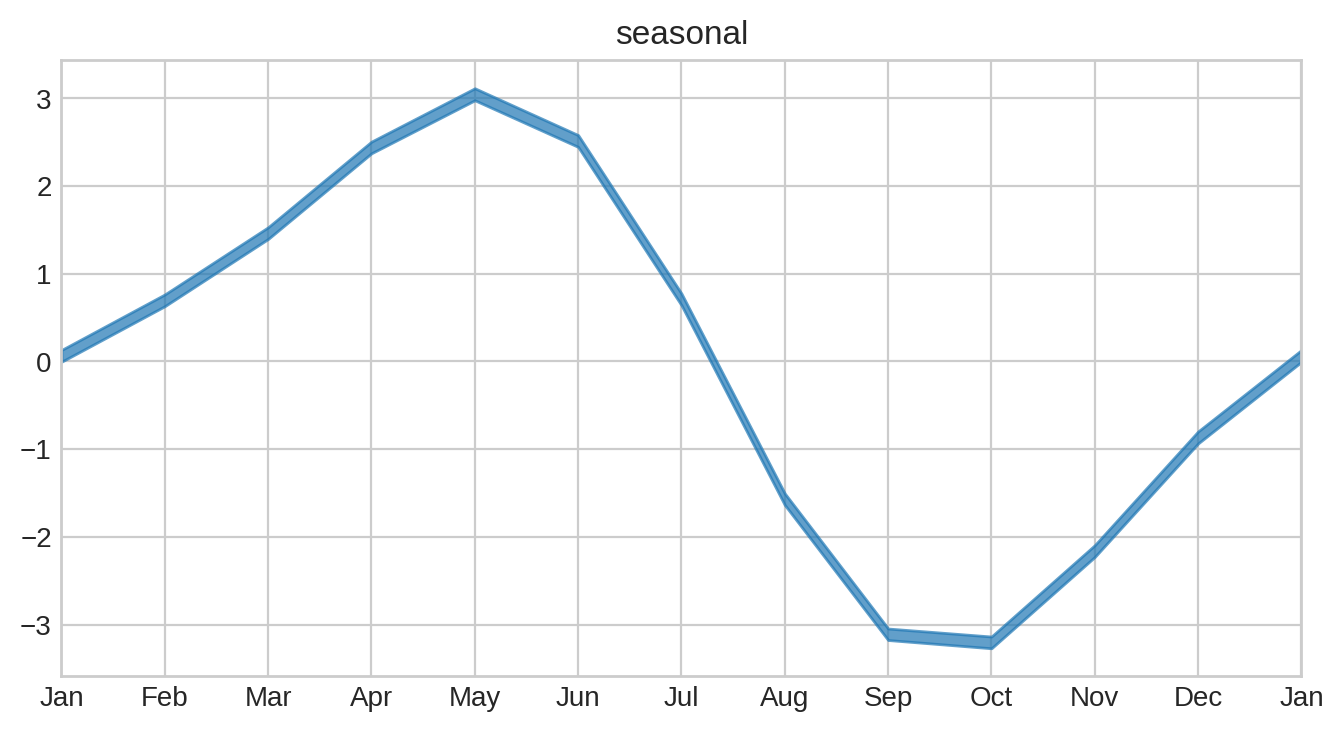

In [8]:
tmp = az.hdi(trd.s.to_numpy().T).T
plt.figure(figsize=(8, 4))
plt.fill_between(range(13), tmp[0], tmp[1], alpha=.7, color='C0')
plt.gca().set(xlim=(0, 12), title='seasonal',
              xticks=range(0, 13),
              xticklabels=[calendar.month_abbr[i%12+1] for i in range(0, 13)])
None

/tmp/ipykernel_2639/2276266944.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.g.to_numpy().T)[:-1].T


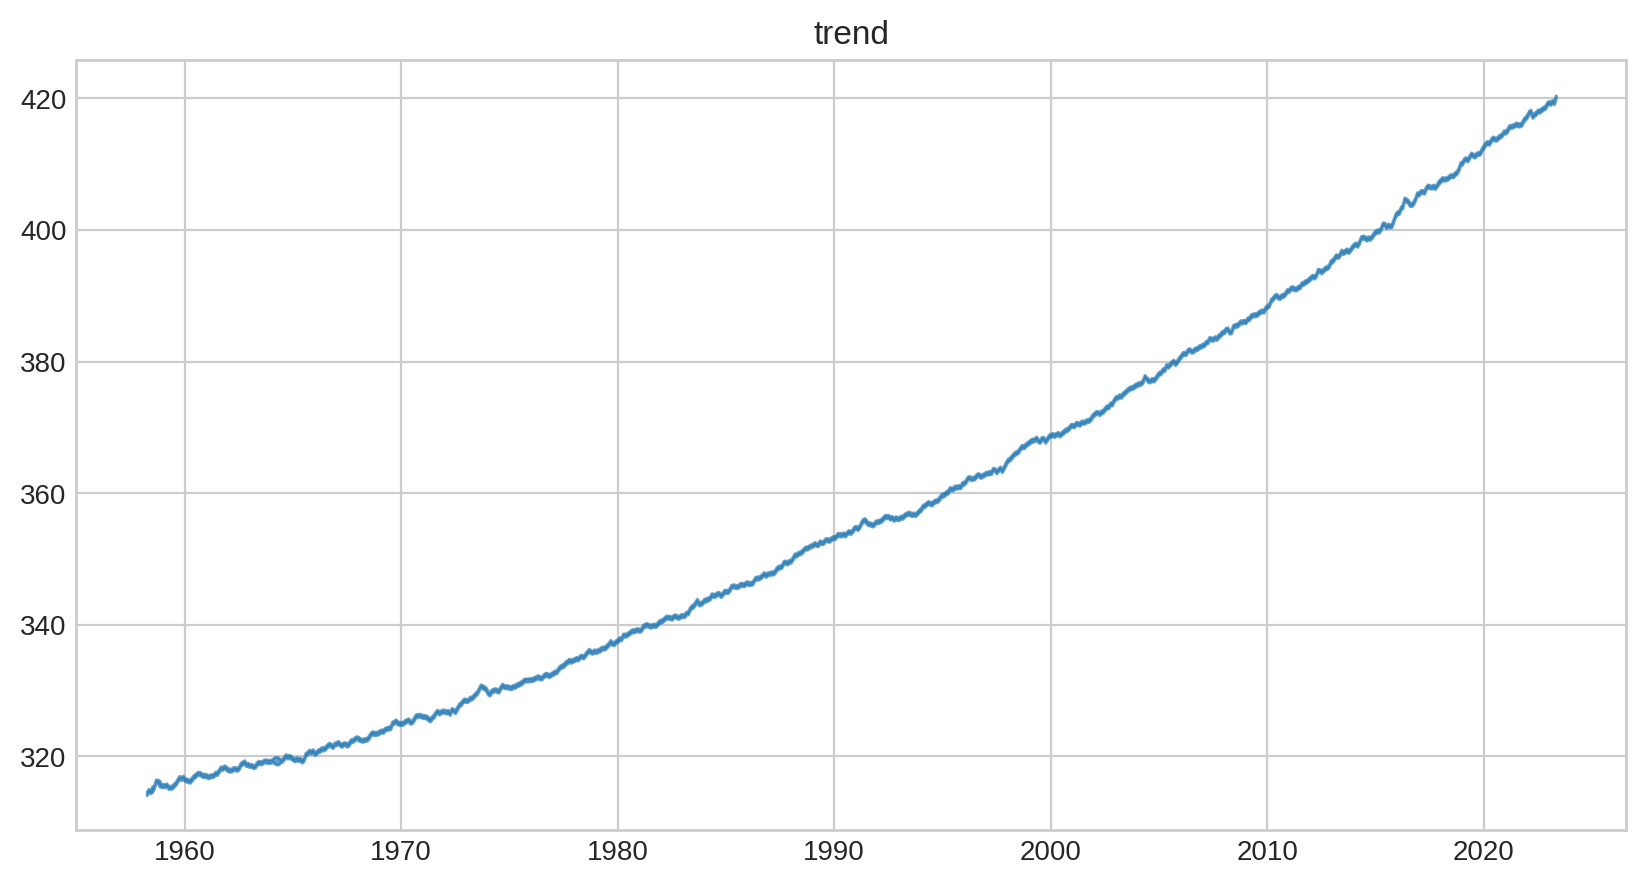

In [9]:
tmp = az.hdi(trd.g.to_numpy().T)[:-1].T
plt.figure(figsize=(10, 5))
plt.fill_between(pd.date_range(data.date.min(), data.date.max(), freq='M'),
                 tmp[0], tmp[1],
                 alpha=.7, color='C0')
plt.gca().set(title='trend')
None

/tmp/ipykernel_2639/2415054865.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.b.to_numpy().T).T


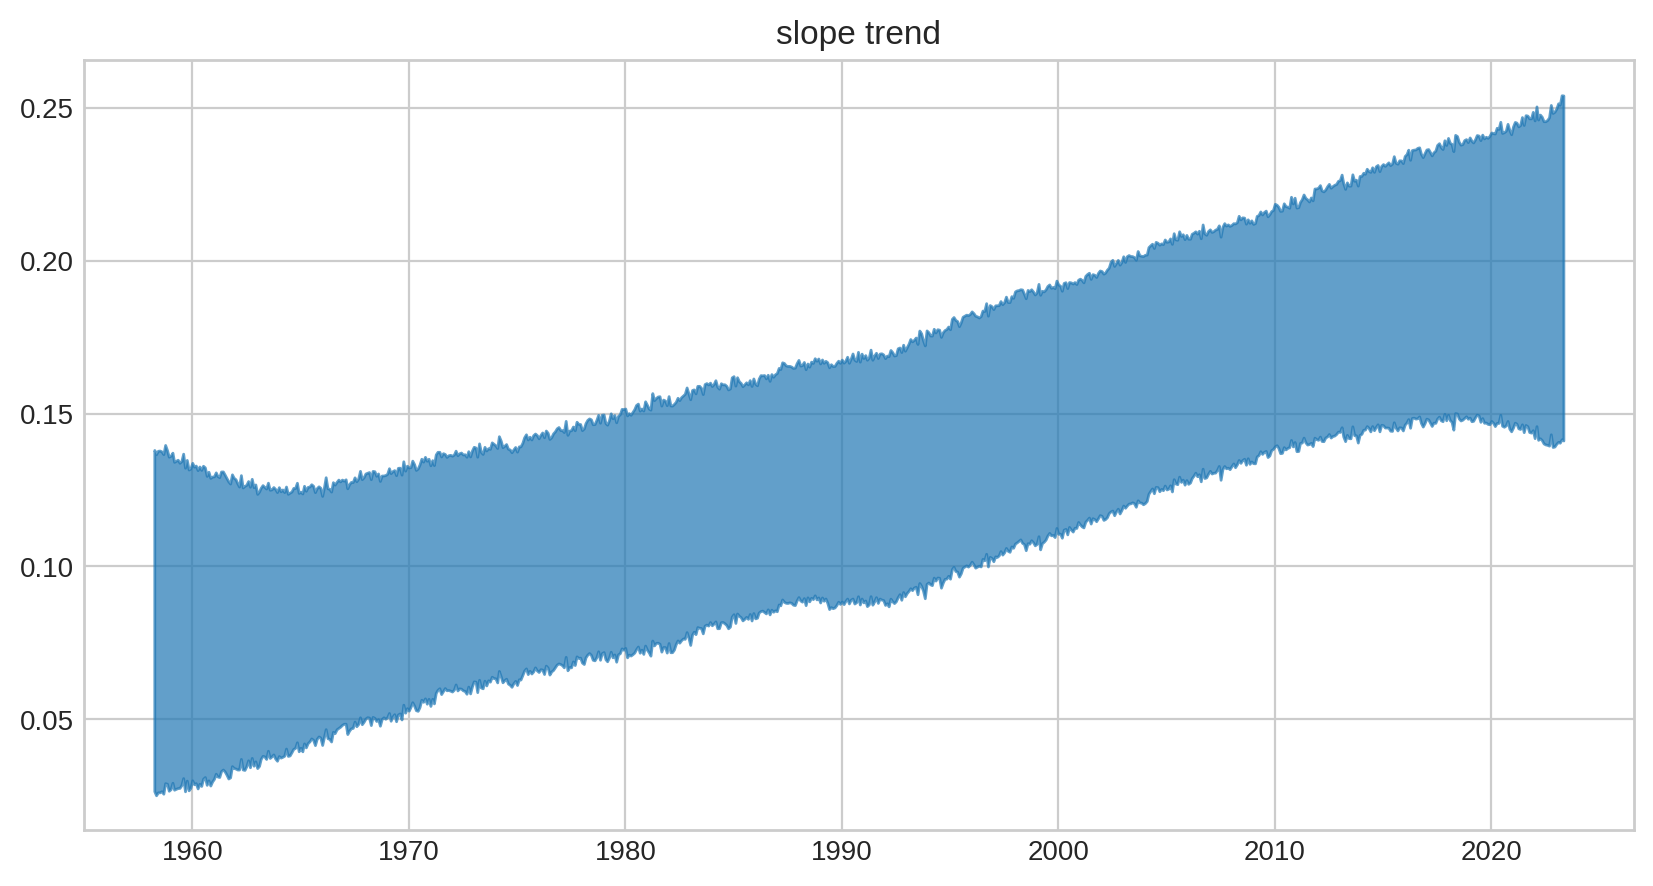

In [10]:
tmp = az.hdi(trd.b.to_numpy().T).T
plt.figure(figsize=(10, 5))
plt.fill_between(pd.date_range(data.date.min(), data.date.max(), freq='M'),
                 tmp[0], tmp[1],
                 alpha=.7, color='C0')
plt.gca().set(title='slope trend')
None

/tmp/ipykernel_2639/2940655784.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.mu.to_numpy()[-48:].T).T


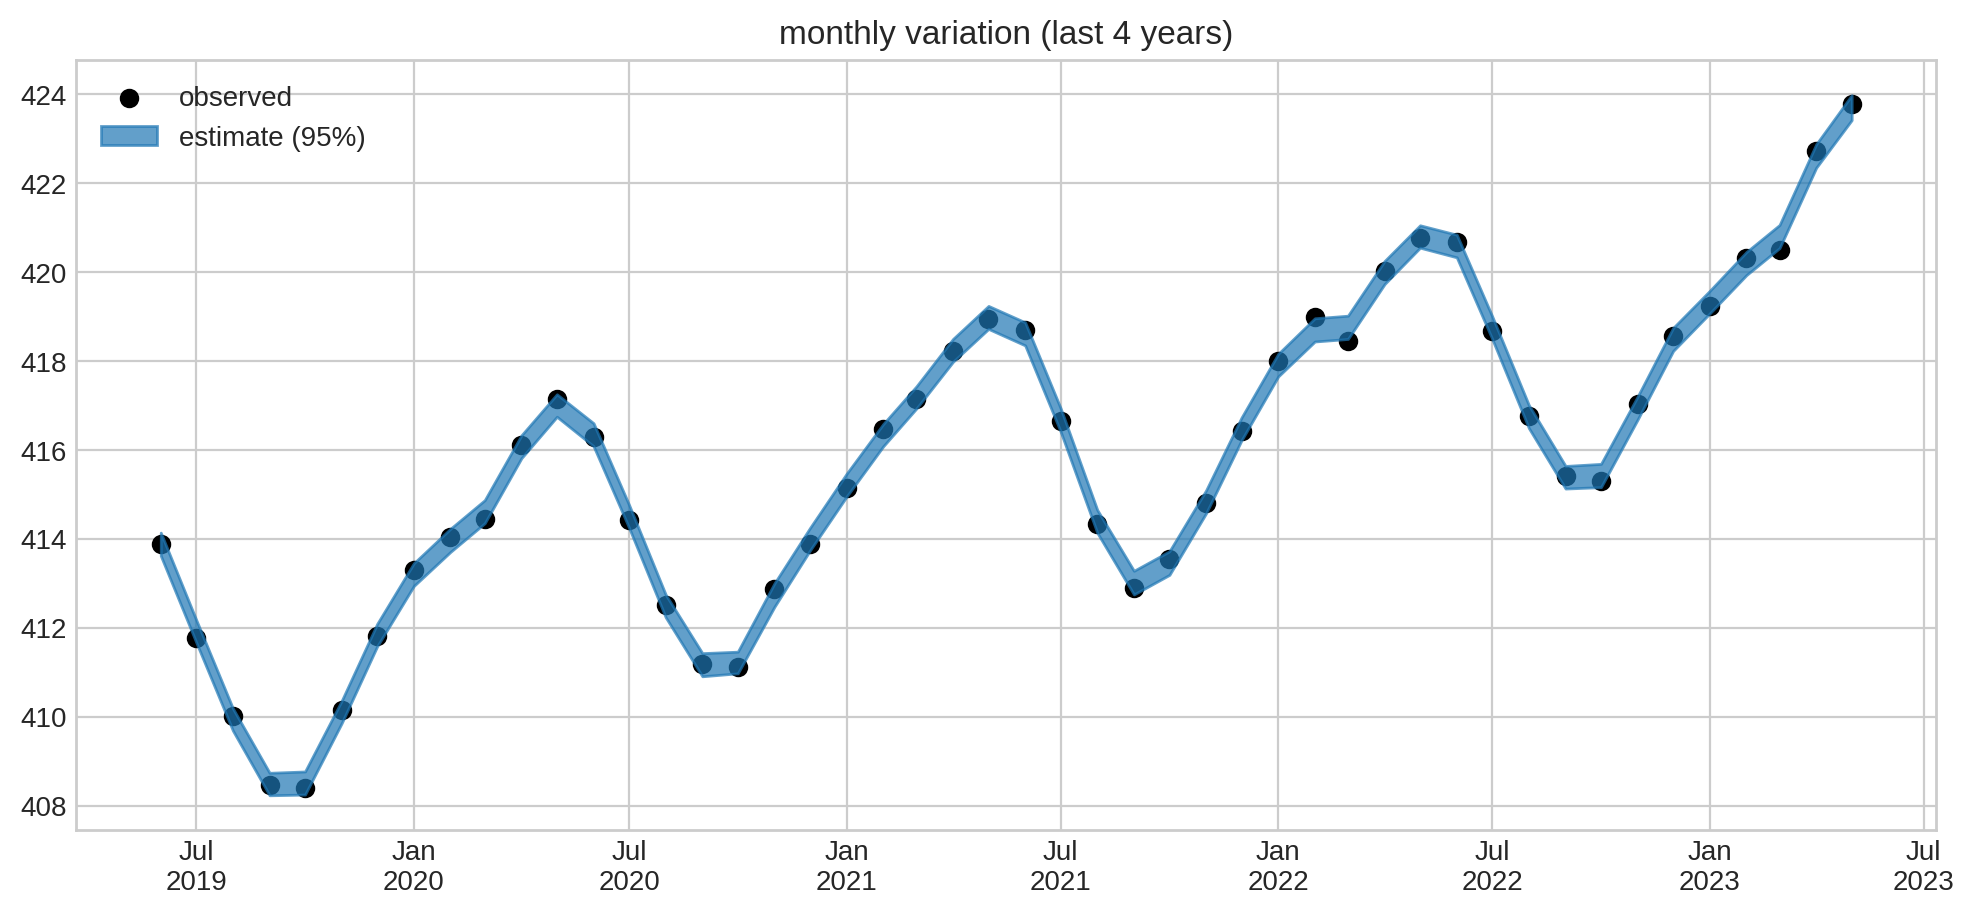

In [11]:
tmp = az.hdi(trd.mu.to_numpy()[-48:].T).T
plt.figure(figsize=(12, 5))
plt.scatter(data.date[-48:], data.CO2[-48:],
            label='observed', c='k')
plt.fill_between(data.date[-48:], tmp[0], tmp[1],
                 alpha=.7, color='C0', label='estimate (95%)')
plt.gca().set(title='monthly variation (last 4 years)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
plt.legend()
plt.savefig('monthly_var.svg')
None